In [1]:
import pandas as pd
import numpy as np
import pycmap ## having trouble with importing pycmap .. idk why .. maybe because of environment ??
import os.path
from datetime import datetime, timedelta
import pytz
import matplotlib.pyplot as plt
import math
import requests
from bs4 import BeautifulSoup
import re

#from google.auth.transport.requests import Request
#from google.oauth2.credentials import Credentials
#from google_auth_oauthlib.flow import InstalledAppFlow
#from googleapiclient.discovery import build
#from googleapiclient.errors import HttpError

In [2]:
# calls api from cmap and uses my token to do that
api = pycmap.API(token = "4ffc0c87-8372-4fc2-98ec-cf1f64faafa7")

In [3]:
def read_sfl(x):
    df = pd.read_csv(x, sep = '\t')
    cruise_split = x.rsplit('/',1)[-1]
    #output will be a string
    cruise_short = cruise_split.replace('.sfl', '')
    cruise_list = cruise_short.split('_')
    if len(cruise_list) > 2:
        cruise = "_".join([cruise_list[0], cruise_list[1]])
    elif len(cruise_list) == 2:
        cruise = cruise_list[0]
    print(cruise)
    df['cruise'] = cruise
    return df

#### .values converts pd.series to list but we had to get string from the list which is the first one 

In [4]:
sfl_g1 = read_sfl('https://raw.githubusercontent.com/seaflow-uw/seaflow-sfl/refs/heads/master/curated/KM1906_740.sfl')
sfl_g2 = read_sfl('https://raw.githubusercontent.com/seaflow-uw/seaflow-sfl/refs/heads/master/curated/SCOPE_16_751.sfl')
sfl_g3 = read_sfl('https://raw.githubusercontent.com/seaflow-uw/seaflow-sfl/refs/heads/master/curated/MGL1704_740.sfl')

KM1906
SCOPE_16
MGL1704


In [10]:
sfl_g1

,FILE,DATE,FILE DURATION,LAT,LON,CONDUCTIVITY,SALINITY,OCEAN TEMP,PAR,BULK RED,STREAM PRESSURE,EVENT RATE,cruise
0,2019_100/2019-04-10T02-52-58+00-00,2019-04-10T02:52:58+00:00,180.140,21.2641,-158.1762,2.9670,18.5518,25.3477,1012.8710,43.1428,7.61,5574.64,KM1906
1,2019_100/2019-04-10T02-55-58+00-00,2019-04-10T02:55:58+00:00,180.118,21.2641,-158.1761,2.9576,18.4940,25.3450,1045.7315,43.1428,12.00,3984.22,KM1906
2,2019_100/2019-04-10T02-58-58+00-00,2019-04-10T02:58:58+00:00,180.081,21.2640,-158.1761,2.8883,18.0079,25.3550,1016.4360,43.1428,12.00,3869.74,KM1906
3,2019_100/2019-04-10T03-01-59+00-00,2019-04-10T03:01:59+00:00,180.149,21.2637,-158.1764,2.8479,17.7352,25.3828,1601.7908,22.1153,12.00,3950.45,KM1906
4,2019_100/2019-04-10T03-04-59+00-00,2019-04-10T03:04:59+00:00,180.130,21.2647,-158.1790,2.8259,17.5885,25.4430,1489.4042,22.1153,12.00,4104.72,KM1906
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8943,2019_119/2019-04-29T17-36-29+00-00,2019-04-29T17:36:29+00:00,180.099,21.9710,-158.2559,5.3313,35.0436,24.8751,649.2537,21.6736,12.00,10689.29,KM1906
8944,2019_119/2019-04-29T17-39-29+00-00,2019-04-29T17:39:29+00:00,180.114,21.9614,-158.2580,5.3345,35.0459,24.9214,1010.3146,21.6736,12.00,10662.12,KM1906
8945,2019_119/2019-04-29T17-42-30+00-00,2019-04-29T17:42:30+00:00,180.144,21.9520,-158.2599,5.3391,35.0440,24.9522,1586.8503,21.6736,12.00,10671.37,KM1906
8946,2019_119/2019-04-29T17-45-30+00-00,2019-04-29T17:45:30+00:00,180.133,21.9422,-158.2621,5.3400,35.0421,24.9556,1650.7444,21.6736,12.00,10692.36,KM1906


In [5]:
# list of cruises that we want (g1, g2 , and g3)
all_sfl = pd.concat([sfl_g1, sfl_g2, sfl_g3])

In [6]:
all_cruises = ['KM1906', 'SCOPE_16', 'MGL1704'] 

In [7]:
pd.to_datetime(all_sfl['DATE'])
# this converts all_sfl date column from object type to datetime in UTC

datetime_index = pd.DatetimeIndex(all_sfl.DATE.values).tz_convert('UTC')
df2 = all_sfl.set_index(datetime_index).reset_index()
df2.rename(columns={"index": "Date"}, inplace = True)
df2.drop(columns = ['DATE'], inplace = True)

# convert datetime64 to datetimeindex for groupby function to work
## i changed df because i was scared to mess up all_sfl df i was working with so I may have to change code to alter all_sfl df

In [8]:
df3 = df2.dropna(how = 'any', subset = ['LAT', 'LON', 'PAR']).reset_index()

In [9]:
def check_int(value):
    try:
        float(value)
        return np.NaN
    except ValueError:
        return value
## this function is returning bad values found in any column as a series

In [10]:
## dont run twice pls ##

bad_par = df3['PAR'].apply(check_int).dropna()
good_par = bad_par.replace({'-': ''}, regex=True)
df3.loc[good_par.index, 'PAR'] = good_par.values

In [11]:
# cleans up code to get rid of hyphens 
df3.PAR = df3.PAR.astype(float)
np.abs(df3.loc[df3.PAR < -100, 'PAR'])
df3.loc[(df3.PAR.astype(float) < 0) & (df3.PAR.astype(float) > -100), 'PAR'] = 0

In [12]:
sfl_hourly = df3.groupby([pd.Grouper(key = 'Date', freq = 'H'), 'cruise', 'LAT']).agg({'PAR': 'mean'}).reset_index()
sfl_hourly

,Date,cruise,LAT,PAR
0,2016-04-20 00:00:00+00:00,SCOPE_16,21.4542,1939.9000
1,2016-04-20 00:00:00+00:00,SCOPE_16,21.4614,1939.9000
2,2016-04-20 00:00:00+00:00,SCOPE_16,21.4688,1939.9000
3,2016-04-20 00:00:00+00:00,SCOPE_16,21.4760,1939.9000
4,2016-04-20 00:00:00+00:00,SCOPE_16,21.4833,1766.6000
...,...,...,...,...
17889,2019-04-29 17:00:00+00:00,KM1906,22.0385,1655.6501
17890,2019-04-29 17:00:00+00:00,KM1906,22.0483,1415.4104
17891,2019-04-29 17:00:00+00:00,KM1906,22.0581,1036.7075
17892,2019-04-29 17:00:00+00:00,KM1906,22.0680,725.5600


In [13]:
df3.PAR = 10**-6 * df3.PAR * 24 * 60 * 60
# time to convert PAR units from microeinstein to einstein to match satellite date

In [14]:
lat_value = df3[df3.LAT.notnull()]
lon_value = df3[df3.LON.notnull()]
# here i've set indexed out the NaN values in lat and lon column before putting it into groupby function

sfl_daily = df3.groupby([pd.Grouper(key = 'Date', freq = 'D'), 'cruise']).agg({
    'PAR': 'mean',
    'LAT': ['min', 'max'],
    'LON': ['min', 'max']}).reset_index()
# using group by to get the daily mean of par based on cruise, ship, etc. and removes any NaN values found. gets minimum and max of lat and lon based on daily scale

sfl_daily['sat_PAR'] = ''
# cretes empty column for sat_par that will be input by cmap data later

sfl_daily.columns = [' '.join(col).strip() for col in sfl_daily.columns.values]
# this flattens the multindex and joins the diff levels to create a min and max lat and lon instead of duplicate lat and lon columns

In [15]:
# cleaning up min_lat values
clean_sfl = sfl_daily.replace([np.inf, -np.inf], np.nan).dropna(subset=["LAT min", 
                                                            "LAT max",
                                                            'LON min',
                                                            'LON max'], how="any")

In [16]:
# colocalizing cmap data, sepcifically modis par data

for index,row in clean_sfl.iterrows():
    df = api.space_time(table='tblModis_PAR',
                   variable='PAR',
                   dt1= str(row['Date']),
                   dt2= str(row['Date']),
                   lat1= row['LAT min'],
                   lat2= row['LAT max'],
                   lon1= row['LON min'],
                   lon2= row['LON max'],
                   depth1=0,
                   depth2=10)
    try:
        clean_sfl.loc[index, 'sat_PAR'] = np.mean(df.PAR)
    except:
        clean_sfl.loc[index, 'sat_PAR'] = np.nan

In [17]:
# calculates the correction factor and makes column in clean_sfl
## i dont think this calculates the correction factor ...
correction = (clean_sfl['sat_PAR'] / clean_sfl['PAR mean'])
clean_sfl['correction'] = correction.astype(float)
cf_sfl = clean_sfl.groupby(['cruise']).median()
cf_sfl

,Date,PAR mean,LAT min,LAT max,LON min,LON max,sat_PAR,correction
cruise,,,,,,,,
KM1906,2019-04-19 12:00:00+00:00,47.105845,33.88015,37.01600,-158.00305,-157.99675,49.282999,1.156616
MGL1704,2017-06-06 12:00:00+00:00,82.777303,34.14850,36.24995,-158.00275,-157.99250,56.645901,0.951089
SCOPE_16,2016-04-27 00:00:00+00:00,38.095849,29.15730,31.95900,-158.01480,-157.97010,53.431466,1.360489


In [18]:
cf_result = cf_sfl['PAR mean'].mul(cf_sfl['correction'], axis = 'index').to_frame()
cf_result1 = cf_result.reset_index()
cf_result1.rename(columns = {0: 'Corrected PAR mean'}, inplace=True) #for some reason this isn't working for renaming
## rename 0 column to correction factor
#cf_result.to_csv('sfl_correction_factors.csv')
cf_result1

,cruise,Corrected PAR mean
0,KM1906,54.483373
1,MGL1704,78.728622
2,SCOPE_16,51.828985


In [19]:
sfl_hourly.rename(columns={'PAR': 'Uncalibrated PAR'}, inplace=True)
sfl_hourly

,Date,cruise,LAT,Uncalibrated PAR
0,2016-04-20 00:00:00+00:00,SCOPE_16,21.4542,1939.9000
1,2016-04-20 00:00:00+00:00,SCOPE_16,21.4614,1939.9000
2,2016-04-20 00:00:00+00:00,SCOPE_16,21.4688,1939.9000
3,2016-04-20 00:00:00+00:00,SCOPE_16,21.4760,1939.9000
4,2016-04-20 00:00:00+00:00,SCOPE_16,21.4833,1766.6000
...,...,...,...,...
17889,2019-04-29 17:00:00+00:00,KM1906,22.0385,1655.6501
17890,2019-04-29 17:00:00+00:00,KM1906,22.0483,1415.4104
17891,2019-04-29 17:00:00+00:00,KM1906,22.0581,1036.7075
17892,2019-04-29 17:00:00+00:00,KM1906,22.0680,725.5600


In [23]:
new_PAR = []

for index, row in sfl_hourly.iterrows():
    if row['cruise'] == 'SCOPE_16':
        new_par_value = row['Uncalibrated PAR'] * 1.36
        new_PAR.append(new_par_value)
    elif row['cruise'] == 'MGL1704':
        new_par_value = row['Uncalibrated PAR'] * 0.95
        new_PAR.append(new_par_value)
    elif row['cruise'] == 'KM1906':
        new_par_value = row['Uncalibrated PAR'] * 1.16
        new_PAR.append(new_par_value)

# sfl_hourly.insert(4, 'New PAR', new_PAR)
sfl_hourly

,Date,cruise,LAT,Uncalibrated PAR,New PAR
0,2016-04-20 00:00:00+00:00,SCOPE_16,21.4542,1939.9000,2638.264000
1,2016-04-20 00:00:00+00:00,SCOPE_16,21.4614,1939.9000,2638.264000
2,2016-04-20 00:00:00+00:00,SCOPE_16,21.4688,1939.9000,2638.264000
3,2016-04-20 00:00:00+00:00,SCOPE_16,21.4760,1939.9000,2638.264000
4,2016-04-20 00:00:00+00:00,SCOPE_16,21.4833,1766.6000,2402.576000
...,...,...,...,...,...
17889,2019-04-29 17:00:00+00:00,KM1906,22.0385,1655.6501,1920.554116
17890,2019-04-29 17:00:00+00:00,KM1906,22.0483,1415.4104,1641.876064
17891,2019-04-29 17:00:00+00:00,KM1906,22.0581,1036.7075,1202.580700
17892,2019-04-29 17:00:00+00:00,KM1906,22.0680,725.5600,841.649600


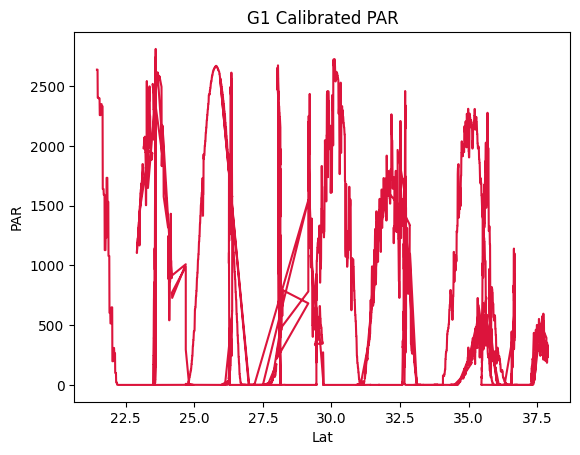

In [49]:
plt.xlabel('Lat')
plt.ylabel('PAR')
plt.title('G1 Calibrated PAR')

g1_p = sfl_hourly.loc[sfl_hourly['cruise'] == 'SCOPE_16']
par1 = g1_p['New PAR']
lat1 = g1_p['LAT']

g2_p = sfl_hourly.loc[sfl_hourly['cruise'] == 'MGL1704']
par2 = g2_p['New PAR']
lat2 = g2_p['LAT']

g3_p = sfl_hourly.loc[sfl_hourly['cruise'] == 'KM1906']
par3 = g3_p['New PAR']
lat3 = g3_p['LAT']


plt.plot(lat1, par1, color = 'crimson')

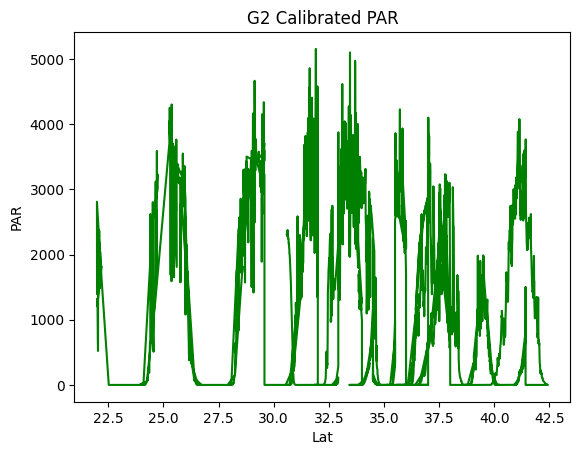

In [51]:
plt.xlabel('Lat')
plt.ylabel('PAR')
plt.title('G2 Calibrated PAR')

plt.plot(lat2, par2, color = 'green')

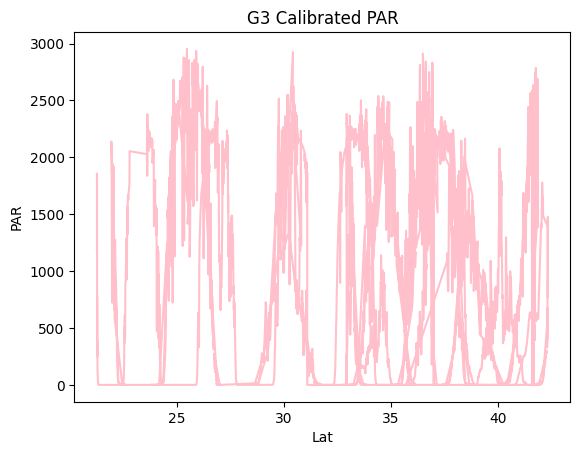

In [52]:
plt.xlabel('Lat')
plt.ylabel('PAR')
plt.title('G3 Calibrated PAR')

plt.plot(lat3, par3, color = 'pink')

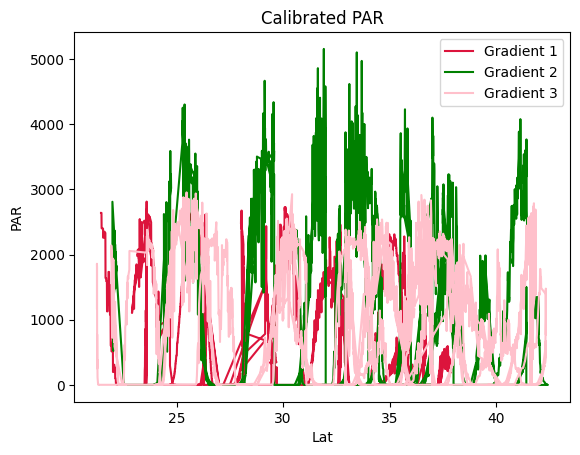

In [48]:
plt.plot(lat1, par1, color = 'crimson', label = 'Gradient 1')
plt.plot(lat2, par2, color = 'green', label = 'Gradient 2')
plt.plot(lat3, par3, color = 'pink', label = 'Gradient 3')

plt.xlabel('Lat')
plt.ylabel('PAR')
plt.title('Calibrated PAR')

plt.legend()